

<h1 style="background-color:blue;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Fake News Detection In Healthcare</h1>

<img title="covid_tweet" alt="covid_tweet" src="doctor fake news.png" width="600"  height="300">  

_Image from labs.openai.com_

## Contents <a id='contents'></a>
1. [Introduction](#intro)
2. [Data Source](#data_source)
3. [Data Preparation](#data_prep)
4. [Model 1: Multinomial Naïve Bayes](#bayes)
5. [Model 2: BERT](#bert) 
6. [Model 3: LSTM Neural Network](#lstm)
7. [Overall Model Evaluation & Conclusion](#evaluation)

<a id='top'></a>

<h1 id='intro'>Introduction</h2>
<p>This notebook contains a comparison of fake news classification modelsn namely Naive Bayes, BERT and a Long Short Term Memory Neural Network. The aim of this project was to evaluate the models in terms of accuracy and f1 score as well as how fast they are at making predictions, so as to propose which model would be best to productionise. The domain of fake news upon which the models are tested is healthcare and the types of news are both long form news articles as well as shorter tweet texts. </p>


<h1 id='data_source'>Data Source</h2>
<p> The data was obtained from two sources, namely the PUBHEALTH dataset available <a href="https://drive.google.com/file/d/1eTtRs5cUlBP5dXsx-FTAlmXuB6JQi2qj/view">here</a> and the Constraint COVID19 Fake News Detection in English Competition available <a href="https://competitions.codalab.org/competitions/26655">here</a>. The respective csv files in the latter source were renamed to tweets1.csv to tweets3.csv.</p>

# Data Preparation<a id='data_prep'></a>

## Installing Dependencies 

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow import keras
from keras import layers, mixed_precision
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras import utils

from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification, BertTokenizer

import pydot
import pydotplus
import graphviz
import seaborn as sns

import timeit

In [2]:
import sys
from helper_func.helper_functions import print_accuracy_f1_time, print_html_table,get_predictions_and_times,plot_accuracy_loss

In [3]:
# setting the verbosity of tensorflow error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# setting tensorflow to ignore GPU
tf.config.experimental.set_visible_devices([], 'GPU')  

## Preparing Pubhealth Dataset

In [4]:
# loading the data
df_pubhealth1 = pd.read_csv("data/PUBHEALTH/dev.tsv", sep='\t', usecols=['main_text', 'label'])
df_pubhealth2 = pd.read_csv("data/PUBHEALTH/test.tsv", sep='\t', usecols=['main_text', 'label'])
df_pubhealth3 = pd.read_csv( "data/PUBHEALTH/train.tsv", sep='\t', usecols=['main_text', 'label'])
df_pubhealth1.head()


,main_text,label
0,"On 8 November 2015, former Twitter user @Fierc...",unproven
1,Topeka television station KSNT reports that th...,true
2,"On 7 March 2016, British tabloid Express repor...",false
3,"In March, the Canadian government urged provin...",true
4,Forest officials say scientists who study nati...,true


The data is composed of text as well as a label. In the cells that follow we shall concatenate the datasets and isolate only the true and false labels.

In [5]:
# concatenate the datasets
df_pubhealth = pd.concat([df_pubhealth1, df_pubhealth2, df_pubhealth3], axis=0)
df_pubhealth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 0 to 9831
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   main_text  12258 non-null  object
 1   label      12253 non-null  object
dtypes: object(2)
memory usage: 288.0+ KB


There are 12258 rows in the fake health dataset (i.e. news articles).

In [6]:
# renaming columns and selecting only the columns required by the models
# rename the "main_text" column
df_pubhealth.rename(columns={'main_text': 'text'}, inplace=True)
# Count the number of rows with null values in the 'main_text' column
null_count = df_pubhealth['text'].isnull().sum()
null_count


30

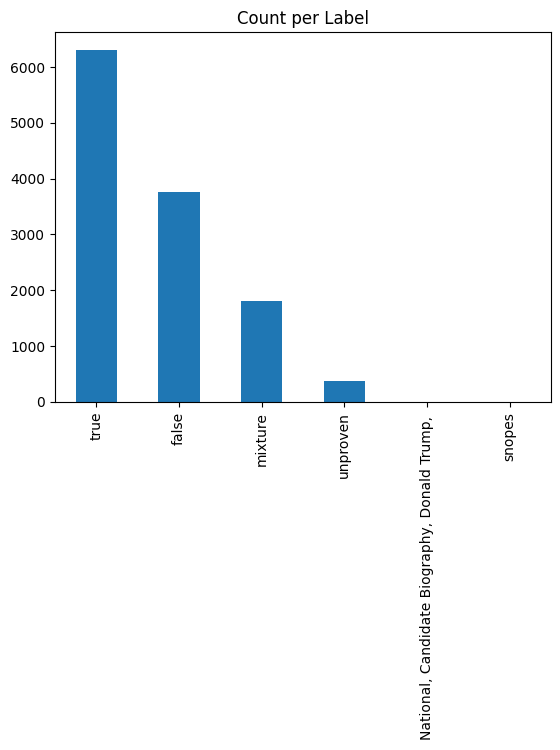

In [7]:
def plot_label_counts(df):
    value_counts = df['label'].value_counts()
    value_counts.plot(kind='bar')
    plt.title("Count per Label")
    plt.show()
    
plot_label_counts(df_pubhealth)

The dataframe does have null values which need to be removed. These will be filtered below.

There are undesirable labels in the dataset (as well as an erroneous row), all of which need to be removed so that only "true" and "false" remain.

In [9]:
# Select rows where the 'main_text' column is not null and the 'label' column contains either 'true' or 'false'
df_filtered = df_pubhealth[pd.notnull(df_pubhealth['text']) 
            & df_pubhealth['label'].isin(['true', 'false'])]
df_filtered.reset_index()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10075 entries, 1 to 9831
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10075 non-null  object
 1   label   10075 non-null  object
dtypes: object(2)
memory usage: 236.1+ KB


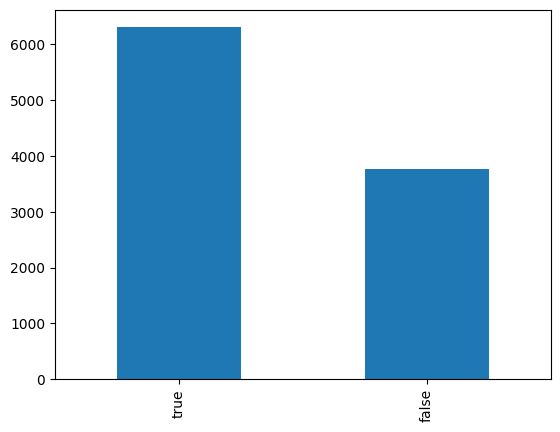

In [10]:
# Get the value counts of the 'label' column in the dataframe and plot them now that the dataframe has been cleaned
value_counts_filtered = df_filtered['label'].value_counts()
value_counts_filtered.plot(kind='bar')
plt.show()


The dataset is unbalanced in terms of label class. The steps that follow involve ascertaining the number of rows for the label with fewer instances, then reducing the number of rows for the other label until the row counts for each label are equal.

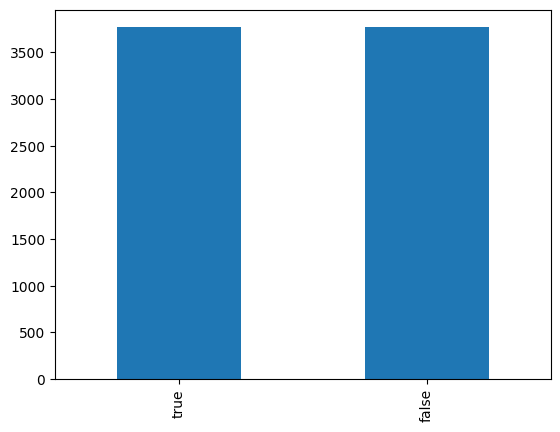

In [11]:
# Balancing the dataset

def balance_dataset(df, label_column):
    # Count the number of instances of each label
    counts = df[label_column].value_counts()
    keep = counts.min()  # Calculate the number of instances to keep for each label
    balanced = []  # Create an empty list to store the balanced dataset

    # Iterate through each label
    for label in ["true", "false"]:
        # Get the rows with the current label
        rows = df[df[label_column] == label]
        # Randomly select the number of instances to keep
        rows = rows.sample(keep, random_state=5)
        balanced.append(rows)  # Add the rows to the balanced dataset

    # Concatenate the rows of the balanced dataset
    balanced_df = pd.concat(balanced)
    return balanced_df


df_balanced = balance_dataset(df_filtered, 'label')
# Get the value counts of the 'label' column in the dataframe and plot them now that the dataframe has been balanced
value_counts_balanced = df_balanced['label'].value_counts()
value_counts_balanced.plot(kind='bar')
plt.show()


As can be seen above, the dataset is now balanced in terms of label class.

## Preparing Tweet Fake News Dataset

In [12]:
# reading the first set of tweet data into a dataframe
df_tweets1 = pd.read_csv("data/tweet_data/tweets1.csv")
df_tweets2 = pd.read_csv("data/tweet_data/tweets2.csv")
df_tweets3 = pd.read_csv("data/tweet_data/tweets3.csv")
df_tweets1.head()


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


Similar to the Pubhealth dataset, the tweet fake news dataset is comprised of tweet text and labels.

In [13]:
# combine the tweet dataframes into a single dataframe
df_tweets = pd.concat([df_tweets1, df_tweets2, df_tweets3], axis=0)
df_tweets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  object
dtypes: int64(1), object(2)
memory usage: 334.4+ KB


There are 10700 tweets in the tweets fake news dataset.

In [14]:
# Replace "real" with "true" and "fake" with "false" in the "label" column
df_tweets['label'] = df_tweets['label'].replace(
    {"real": "true", "fake": "false"})
df_tweets.rename(columns={"tweet": "text"}, inplace=True)
df_tweets = df_tweets[['text', 'label']]
df_tweets.head()


,text,label
0,The CDC currently reports 99031 deaths. In gen...,true
1,States reported 1121 deaths a small rise from ...,true
2,Politically Correct Woman (Almost) Uses Pandem...,false
3,#IndiaFightsCorona: We have 1524 #COVID testin...,true
4,Populous states can generate large case counts...,true


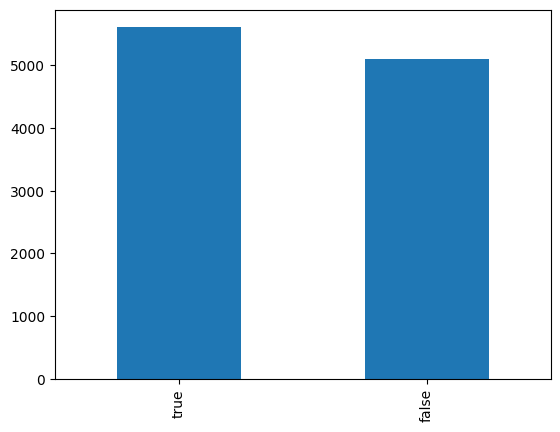

In [15]:
# Filter the dataframe to only return rows where "label" is not null and contains either "true" or "false"
df_filtered_tweets = df_tweets[df_tweets['label'].notnull() 
                   & df_tweets['label'].isin(['true', 'false'])]
# Get the value counts of the 'label' column in the dataframe and plot them
value_counts_filtered = df_filtered_tweets['label'].value_counts()
value_counts_filtered.plot(kind='bar')
plt.show()


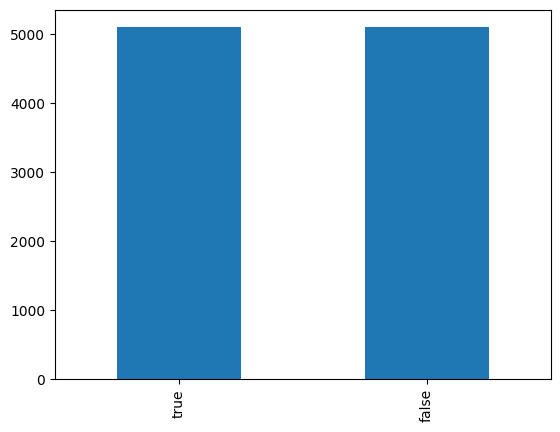

In [16]:
# use the balance_dataset function to create a balanced dataset in terms of label class
df_balanced_tweets = balance_dataset(df_filtered_tweets, 'label')

# Get the value counts of the 'label' column in the dataframe and plot them now that the dataframe has been balanced
value_counts_tweets_labels = df_balanced_tweets['label'].value_counts()
value_counts_tweets_labels.plot(kind='bar')
plt.show()


In [17]:
df_balanced_tweets.head()

,text,label
1170,RT @drharshvardhan: .@MoHFW_INDIA has decided ...,true
1681,We are pleased to announce the inclusion of 4 ...,true
253,The confirmation earlier today of a second dea...,true
1223,@adamwulf We’re largely following the state he...,true
0,Our daily update is published. States reported...,true


# Concatenate the datasets

Now that both datasets have been balanced and have the same column names, they can be concatenated so that the classification models can refer to a single dataframe.

In [18]:
df_combined = pd.concat([df_balanced, df_balanced_tweets], axis=0) # combine news articles and tweets
df_combined = df_combined.reset_index()

# replace labels true and false with 1 and 0
df_combined['label'] = df_combined['label'].replace({'true': 1, 'false': 0})

# save the dataframe to a csv file
df_combined.to_csv('data/df_combined.csv')
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17738 non-null  int64 
 1   text    17738 non-null  object
 2   label   17738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 415.9+ KB


The combined balanced dataset has approximately 18,000 rows.

In [135]:
df_final = df_combined.sample(frac=1, random_state=100) # specify the fraction of rows used for model training by adjusting the 'frac' parameter
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 533 to 5640
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17738 non-null  int64 
 1   text    17738 non-null  object
 2   label   17738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 554.3+ KB


There are 17738 rows in the final dataframe.

# Model 1: Multinomial Naïve Bayes<a id='bayes'></a>

The first attempt at classification involves using a CountVectorizer to vectorize the text.

In [166]:
# Extract the text and label columns
texts = df_final["text"]
labels = df_final["label"]

# # Encode the labels as binary values (0 for 'false', 1 for 'true')
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=100)

# Vectorize the text data using a bag of words approach
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Fit the Naive Bayes model on the training data
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

In [167]:
# Predict on the test data and get the time taken per prediction
y_pred,time_per_prediction_NB= get_predictions_and_times(model_NB,X_test)

In [168]:
# Calculate the accuracy and f1 score
accuracy_NB_count_vec = (y_pred == y_test).mean()
f1_NB_count_vec = f1_score(y_test, y_pred)

print_accuracy_f1_time(accuracy_NB_count_vec,f1_NB_count_vec,time_per_prediction_NB)

Accuracy: 0.78
F1 score: 0.79
Time per prediction: 0.114e-06 seconds


The Naive Bayes model obtained the above scores using count vectorization. Next, TFIDF will be used to vectorize the text. 

In [169]:
# split the data into training and test datasets again, as TFIDF does not use the encoded labels from LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=100)

vectorizer = TfidfVectorizer()  # using TFIDF rather than count vectorization
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Fit the Naive Bayes model on the training data
model_NB.fit(X_train, y_train)

# Predict on the test data and calculate the accuracy and f1 score
y_pred,time_per_prediction_NB= get_predictions_and_times(model_NB,X_test)
accuracy_NB_tfidf = (y_pred == y_test).mean()
f1_NB_tfidf = f1_score(y_test, y_pred)

print_accuracy_f1_time(accuracy_NB_tfidf,f1_NB_tfidf,time_per_prediction_NB)

Accuracy: 0.84
F1 score: 0.83
Time per prediction: 0.828e-07 seconds


Using TFIDF vectorization, the Naïve Bayes model achieved higher scores for both accuracy and F1 score. The time per prediction was faster than for TFIDF than count vectorization.

In [170]:
# create a confusion matrix to evaluate the model
conf_matrix_NB = confusion_matrix(y_test, y_pred)

# Model 2: BERT Classifier<a id='bert'></a>


## BERT Data Preparation

In order for the BERT classifier to use the fake news data it is necessary to convert the dataframe into a Dataset (a special type of data object created by the original authors of BERT).

In [171]:
# convert the dataframe into a dataset, used by the BERT model.
data_for_bert = Dataset.from_pandas(df_final)
data_for_bert

Dataset({
    features: ['index', 'text', 'label', '__index_level_0__'],
    num_rows: 17738
})

In [172]:
# set the type of tokenizer for the BERT model to use the cased pre-trained version as the text being used is cased
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# defining the tokenization function
def tokenize_bert(example):
    try:
        return tokenizer(example['text'], truncation=True)
    except:
        print("Invalid format")

dataset_tokenized = data_for_bert.map(tokenize_bert, batched=True)

# set the policy to be used when the data is batched
data_collator_batch_tensors = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors='tf')

# splitting the dataset into train and test data
dataset_tokenized_split = dataset_tokenized.train_test_split(
    test_size=0.2, shuffle=True, seed=5)
dataset_tokenized_split


  0%|          | 0/18 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14190
    })
    test: Dataset({
        features: ['index', 'text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3548
    })
})

The dataset has been split into train and test data. In the cell below, the respective datasets are converted into tensors.


In [173]:
# prefetch and collate the datasets in batches of tensors
dataset_train = dataset_tokenized_split["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator_batch_tensors,
    batch_size=4,
).prefetch(tf.data.AUTOTUNE)

dataset_validation = dataset_tokenized_split["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator_batch_tensors,
    batch_size=4,
).prefetch(tf.data.AUTOTUNE)


## BERT Model Training

In [174]:
# set the type of classifier to be BERT uncased
checkpoint = 'bert-base-cased'
bert_classifier1 = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [175]:
# setting hyperperamaters
epochs = 10
mini_batches = int((1/epochs)*len(dataset_train))
num_steps = epochs*mini_batches
learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-5,
    decay_steps=num_steps,
    end_learning_rate=0.0,
)

# compiling the BERT model
bert_classifier1.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=['accuracy']
)

# training the BERT model
bert_classifier1_history = bert_classifier1.fit(
    dataset_train,
    steps_per_epoch=int((1/epochs)*len(dataset_train)),
    epochs=epochs,
    validation_data=dataset_validation,
    validation_steps=len(dataset_validation)
)

Epoch 1/10
354/354 [==============================] - 1556s 4s/step - loss: 0.5042 - accuracy: 0.7175 - val_loss: 0.4522 - val_accuracy: 0.8391
Epoch 2/10
354/354 [==============================] - 1549s 4s/step - loss: 0.3004 - accuracy: 0.8792 - val_loss: 0.3759 - val_accuracy: 0.8670
Epoch 3/10
354/354 [==============================] - 1536s 4s/step - loss: 0.2863 - accuracy: 0.8771 - val_loss: 0.2462 - val_accuracy: 0.9070
Epoch 4/10
354/354 [==============================] - 1568s 4s/step - loss: 0.2726 - accuracy: 0.8912 - val_loss: 0.2201 - val_accuracy: 0.9118
Epoch 5/10
354/354 [==============================] - 1578s 4s/step - loss: 0.2531 - accuracy: 0.8891 - val_loss: 0.2060 - val_accuracy: 0.9211
Epoch 6/10
354/354 [==============================] - 1578s 4s/step - loss: 0.2447 - accuracy: 0.8948 - val_loss: 0.2013 - val_accuracy: 0.9183
Epoch 7/10
354/354 [==============================] - 1531s 4s/step - loss: 0.2072 - accuracy: 0.9174 - val_loss: 0.1937 - val_accuracy:

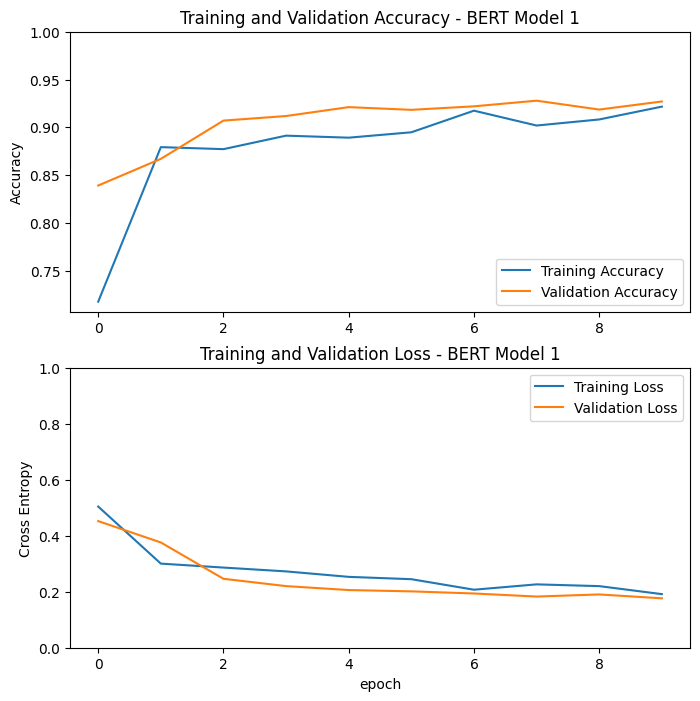

In [176]:
plot_accuracy_loss(bert_classifier1_history,"BERT Model 1")

After several training cycles, it was determined that training the model for 3 epochs yielded the best results. Training and validation accuracy diverged at this point.

In [179]:
# define the model
bert_classifier2 = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1)
    
# setting hyperperamaters
epochs = 3

# compiling the BERT model
bert_classifier2.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=['accuracy']
)
# training the BERT model
bert_classifier2_history = bert_classifier2.fit(
    dataset_train,
    steps_per_epoch=int((1/epochs)*len(dataset_train)),
    epochs=epochs,
    validation_data=dataset_validation,
    validation_steps=len(dataset_validation)
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1182/1182 [==============================] - 3469s 3s/step - loss: 0.3685 - accuracy: 0.8306 - val_loss: 0.2364 - val_accuracy: 0.9050
Epoch 2/3
1182/1182 [==============================] - 3424s 3s/step - loss: 0.2363 - accuracy: 0.9036 - val_loss: 0.1952 - val_accuracy: 0.9202
Epoch 3/3
1182/1182 [==============================] - 3459s 3s/step - loss: 0.2034 - accuracy: 0.9156 - val_loss: 0.1796 - val_accuracy: 0.9273


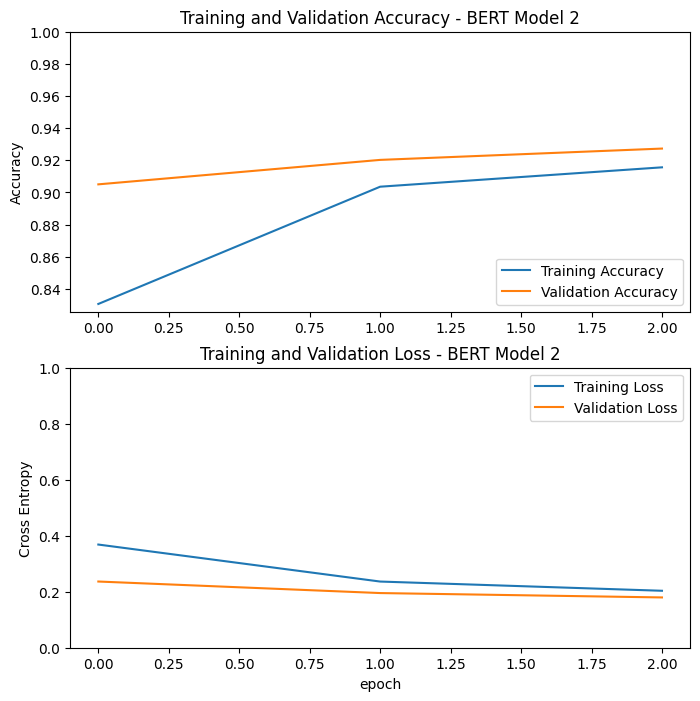

In [180]:
plot_accuracy_loss(bert_classifier2_history,"BERT Model 2")

## BERT Model Evaluation

In [181]:
bert_predictions,time_per_prediction_BERT= get_predictions_and_times(bert_classifier2,dataset_validation)


887/887 [==============================] - 726s 817ms/step


In [182]:
# convert the float value predictions to integers for purpose of comparison with test integers
y_pred_bert = tf.round(tf.nn.sigmoid(bert_predictions['logits']))
# set test data y values
y_test_bert = dataset_tokenized_split['test']['label']
# compare predicted vs actual y values
bert_accuracy = accuracy_score(y_test_bert, y_pred_bert)
bert_f1_score = f1_score(y_test_bert, y_pred_bert, average='weighted')

print_accuracy_f1_time(bert_accuracy,bert_f1_score,time_per_prediction_BERT)

Accuracy: 0.93
F1 score: 0.93
Time per prediction: 0.205 seconds


The BERT model achieved the above accuracy and F1 score, which is an improvement over the benchmark set by the Naive Bayes model. However, as can be seen by the time taken per prediction, the model is several orders of magnitude slower than the Naive Bayes model.

In [183]:
# Create a confusion matrix to evaluate the mdodel
conf_matrix_BERT = confusion_matrix(y_test_bert, y_pred_bert)

# Model 3: LSTM Neural Network<a id='lstm'></a>

The next model will a Long Short Term (LSTM) Neural Network

In [136]:
# splitting into training and test data for the neural network which requires numpy inputs
X_train, X_test, y_train, y_test = train_test_split(
    df_final['text'].to_numpy(),
    df_final['label'].to_numpy(),
    test_size=0.2,
    stratify=df_final['label'].to_numpy(),
    random_state=100)


In [137]:
# set the maximum number of tokens received by the text vectorizer to be the maximum number of words in the longest news article
max_words = max([len(x.split()) for x in X_train])
max_words

7067

In [139]:
# set the maximum length of each input sequence of words
max_len = 100
# set maximum size of word embeddings
embed_size = 300
# specify tokenizer with adequate maximum length to allow for the longest news article
tokenizer = text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
# tokenize training and test data
tokenized_train = tokenizer.texts_to_sequences(X_train) 
tokenized_test = tokenizer.texts_to_sequences(X_test)
# convert train and test data to padded sequences
X_train_seq = utils.pad_sequences(tokenized_train, maxlen=max_len)
X_test_seq = utils.pad_sequences(tokenized_test, maxlen=max_len)


In [156]:
# add layers to the model
def initialize_LSTM(nodes):
    """
    Creates a new Long Short Term Memory Neural Network with the number of nodes as input.
    """
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(max_words, output_dim=embed_size,
            input_length=max_len, trainable=False))
    model_LSTM.add(LSTM(nodes, input_shape=(10, 32), return_sequences=True))
    model_LSTM.add(Dropout(0.2)) 
    model_LSTM.add(layers.GlobalAveragePooling1D())
    model_LSTM.add(Dense(1, activation='sigmoid'))

    model_LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    print(model_LSTM.summary())
    return model_LSTM

model_LSTM = initialize_LSTM(nodes=64)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 300)          2120100   
                                                                 
 lstm_21 (LSTM)              (None, 100, 64)           93440     
                                                                 
 dropout_85 (Dropout)        (None, 100, 64)           0         
                                                                 
 global_average_pooling1d_15  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,213,605
Trainable params: 93,505
Non-trainable params: 2,120,100
______________________________________

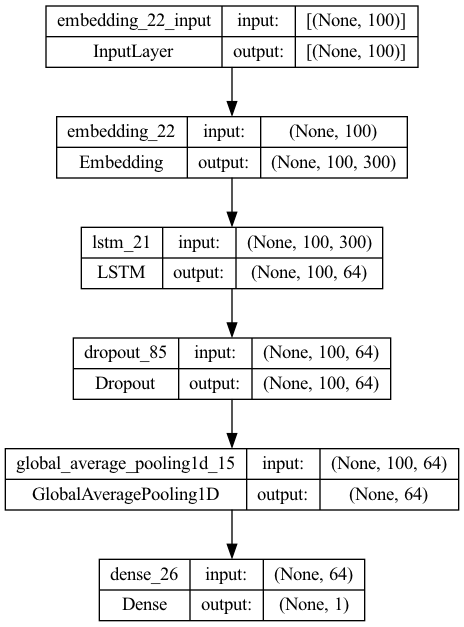

In [186]:
tf.keras.utils.plot_model(model_LSTM,show_shapes=True)

In [157]:
def get_history_LSTM(model,epochs):
    """
    Obtains the model history from fitting a given model with the number of epochs as input.
    """
    history_LSTM = model.fit(
    X_train_seq,
    y_train,
    epochs=epochs,
    validation_data=(X_test_seq, y_test)
    )
    return history_LSTM

# obtaining model history
history_LSTM = get_history_LSTM(model_LSTM,epochs=20)


Epoch 1/20
444/444 [==============================] - 22s 48ms/step - loss: 0.6447 - accuracy: 0.6118 - val_loss: 0.5910 - val_accuracy: 0.7136
Epoch 2/20
444/444 [==============================] - 21s 47ms/step - loss: 0.5607 - accuracy: 0.7146 - val_loss: 0.5511 - val_accuracy: 0.7117
Epoch 3/20
444/444 [==============================] - 21s 48ms/step - loss: 0.5063 - accuracy: 0.7559 - val_loss: 0.5198 - val_accuracy: 0.7430
Epoch 4/20
444/444 [==============================] - 21s 48ms/step - loss: 0.4843 - accuracy: 0.7750 - val_loss: 0.4945 - val_accuracy: 0.7652
Epoch 5/20
444/444 [==============================] - 22s 49ms/step - loss: 0.4581 - accuracy: 0.7893 - val_loss: 0.4633 - val_accuracy: 0.7790
Epoch 6/20
444/444 [==============================] - 22s 49ms/step - loss: 0.4392 - accuracy: 0.8000 - val_loss: 0.4434 - val_accuracy: 0.7875
Epoch 7/20
444/444 [==============================] - 21s 47ms/step - loss: 0.4261 - accuracy: 0.8051 - val_loss: 0.4510 - val_accuracy:

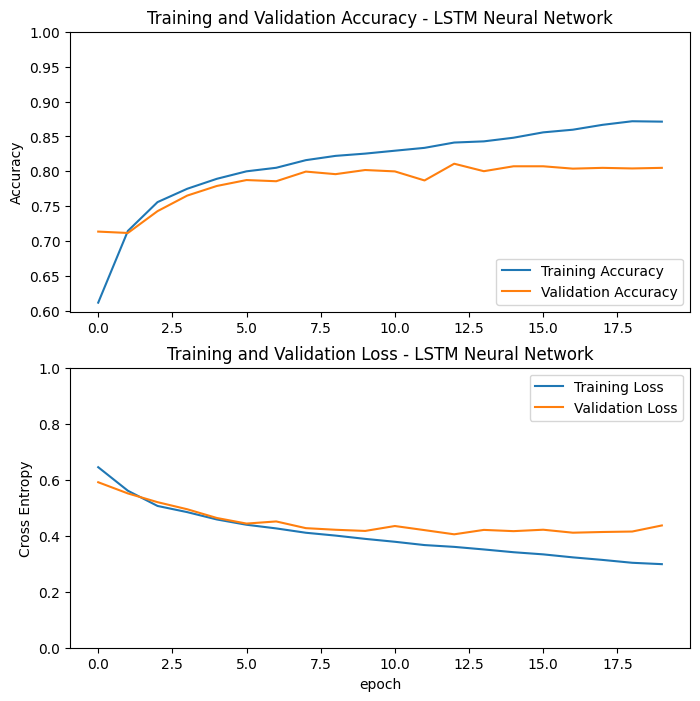

In [158]:
plot_accuracy_loss(history_LSTM,"LSTM Neural Network")

In [159]:
# reinitializing the model and fitting the model with the optimum number of epochs 
model_LSTM_optimised = initialize_LSTM(nodes=64)
history_LSTM_optimised = get_history_LSTM(model_LSTM_optimised,epochs=5)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 300)          2120100   
                                                                 
 lstm_22 (LSTM)              (None, 100, 64)           93440     
                                                                 
 dropout_86 (Dropout)        (None, 100, 64)           0         
                                                                 
 global_average_pooling1d_16  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,213,605
Trainable params: 93,505
Non-trainable params: 2,120,100
______________________________________

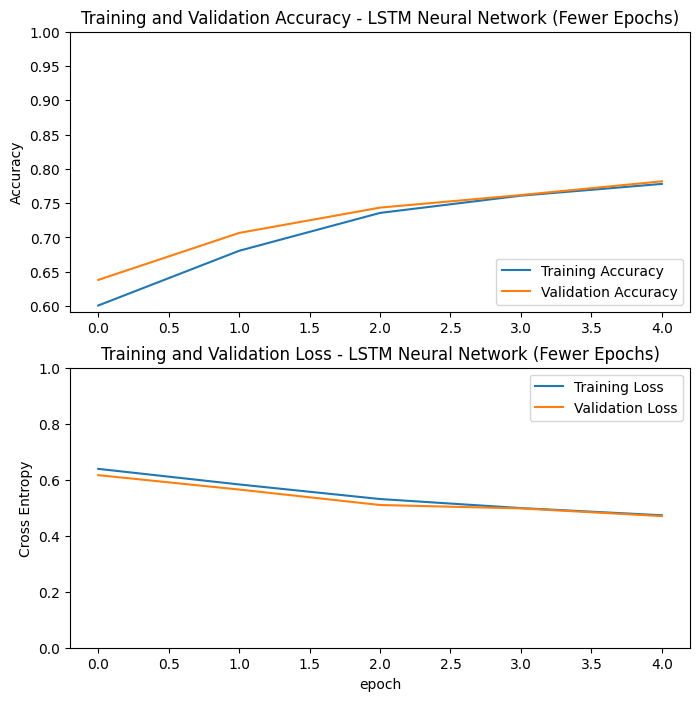

In [160]:
plot_accuracy_loss(history_LSTM_optimised,"LSTM Neural Network (Fewer Epochs)")

In [161]:
LSTM_predictions, time_per_prediction_LSTM = get_predictions_and_times(model_LSTM_optimised,X_test_seq)

111/111 [==============================] - 2s 19ms/step


In [162]:
# Predict on the test data and calculate the accuracy and f1 score
LSTM_predictions_binary = np.round(LSTM_predictions).flatten()  # convert the predictions to 1 or 0
accuracy_LSTM = accuracy_score(y_test, LSTM_predictions_binary)
f1_LSTM = f1_score(y_test, LSTM_predictions_binary)

print_accuracy_f1_time(accuracy_LSTM,f1_LSTM,time_per_prediction_LSTM)

Accuracy: 0.78
F1 score: 0.77
Time per prediction: 0.657e-04 seconds


In [163]:
# create a confusion matrix for the neural network
conf_matrix_LSTM = confusion_matrix(y_test, LSTM_predictions_binary)

# Overall Model Evaluation & Conclusion<a id='evaluation'></a>

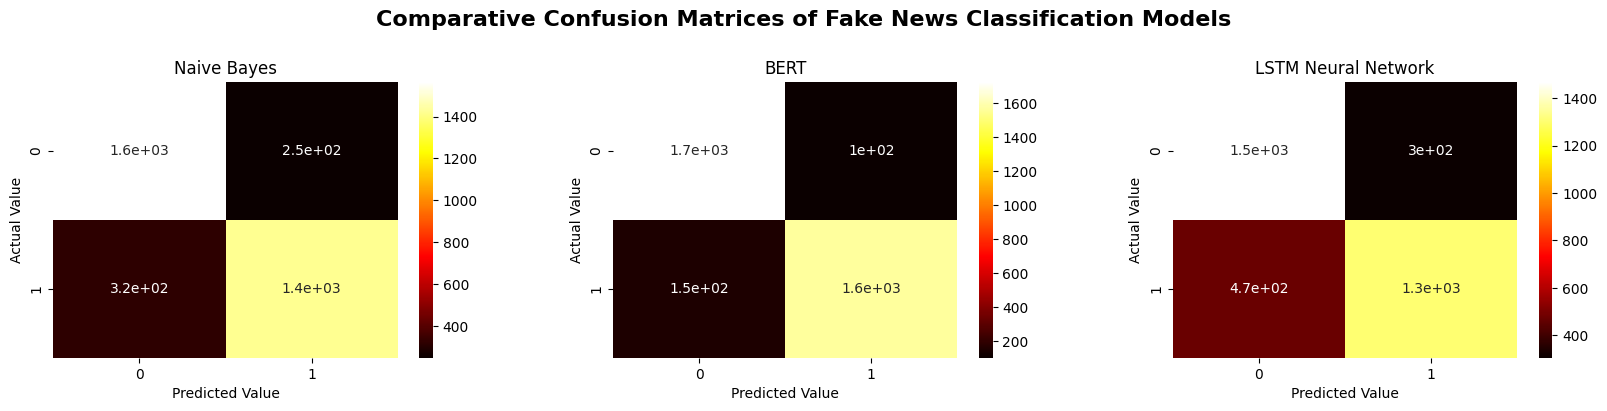

In [184]:
# Plotting confusion matrices of the respective models
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4)) # Create a figure with three subplots

# Plot each heatmap in a different subplot
sns.heatmap(conf_matrix_NB, ax=axs[0], cmap='hot', annot=True)
sns.heatmap(conf_matrix_BERT, ax=axs[1], cmap='hot', annot=True)
sns.heatmap(conf_matrix_LSTM, ax=axs[2], cmap='hot', annot=True)


# Add titles and axis labels to each subplot
axs[0].set_title('Naive Bayes')
axs[1].set_title('BERT')
axs[2].set_title('LSTM Neural Network')
plt.suptitle('Comparative Confusion Matrices of Fake News Classification Models', fontsize=16, fontweight='bold')

for ax in axs.flat:
    ax.set(xlabel='Predicted Value', ylabel='Actual Value')

# Add a colorbar to each subplot
cb1 = axs[0].collections[0].colorbar
cb2 = axs[1].collections[0].colorbar
cb3 = axs[2].collections[0].colorbar

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3,top=0.8)

# Show the plot
plt.show()

Both Naive Bayes and BERT confusion matrices indicate a high level of true positive and true negative classification, with the BERT classifier being slightly better than the Naive Bayes model. This visualization shows how the LSTM Neural Network identified more false negatives than the other two models.



In [ ]:
table = print_html_table(accuracy_NB_tfidf,
    bert_accuracy,
    accuracy_LSTM, 
    f1_NB_tfidf,
    bert_f1_score,
    f1_LSTM, 
    time_per_prediction_NB,
    time_per_prediction_BERT,
    time_per_prediction_LSTM)
print(table)

||  Naive Bayes Classifier | BERT Classifier| LSTM Neural Network|
|----------|----------|----------|----------|
Accuracy| 0.84  | 0.93  |0.78|
F1 Score| 0.83  | 0.93  |0.77|
Time per prediction| 0.828e-07 seconds | 0.205 seconds |0.657e-04 seconds|

The BERT model achieves the highest accuracy and F1 scores, at the cost of much longer time per prediction (7 orders of magnitude greater than the Naive Bayes model and 4 orders of magnitude greater than the LSTM neural network). This makes the performance of the Naive Bayes model, with the second highest accuracy and F1 scores, impressive as it had the fastest time per prediction. It is also worth noting that the Naive Bayes model takes very little time to fit to the data, unlike the other two models that require long training periods. 

In terms of a critique, the accuracy of the LSTM neural network can likely be improved with more hyperparameter tuning. Unfortunately this is a timeous process as each time a parameter is tuned the model must be retrained. 

In light of the decent accuracy score and the fast prediction time, the Naive Bayes classifier would be the best candidate for productionisation.
